# Credit Card Default
August 13, 2019<br>Ngoc, ETL & EDA

-----------------------------------------------------------------

In this notebook, we will perform:
- data cleaning,
- exploratory data analysis, and
- feature engineering

in order to be ready for the modeling step.

----------------------------------------------

# Import

In [1]:
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

sns.set_style("whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)

Change directory to get data source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

# ETL & EDA

## Load data

Change directory to get data:

In [5]:
cd = change_directory.ChangeDirectory()

In [6]:
cd.change_to_data_dir()

Load data:

In [7]:
ccd_df = pd.read_excel("raw/default of credit card clients.xls", header=1)

Change back to notebook directory:

In [8]:
cd.change_to_notebook_dir()

## Explore data

Quick peek into the data:

In [9]:
ccd_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
ccd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

No missing data.

Duplicates?

In [11]:
sum(ccd_df.duplicated())

0

Good.

### default payment next month
Default Payment: ```Yes = 1``` & ```No = 0```.<br>This is our response variable.

In [12]:
ccd_df["default payment next month"].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [13]:
ccd_df["default payment next month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

There is a modest class imbalance. We will try over-sampling, under-sampling, and SMOTE. We will try algorithms which often perform well on imbalanced datasets (decision tree algorithms like C4.5, C5.0, CART, and/or Random Forest, etc.).

Change variable's name to DEFAULT:

In [14]:
ccd_df.rename(columns={"default payment next month": "DEFAULT"}, inplace=True)

### ID
ID of each client.

In [15]:
ccd_df.ID.nunique()

30000

In [16]:
ccd_df.ID.head()

0    1
1    2
2    3
3    4
4    5
Name: ID, dtype: int64

In [17]:
ccd_df.ID.tail()

29995    29996
29996    29997
29997    29998
29998    29999
29999    30000
Name: ID, dtype: int64

Just indexing. We don't need it.

In [18]:
ccd_df.drop("ID", axis=1, inplace=True)

### LIMIT_BAL
Amount of the given credit (NT dollar): includes both the individual consumer credit and his/her family (supplementary) credit.

In [19]:
ccd_df.LIMIT_BAL.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

Text(0, 0.5, 'Count')

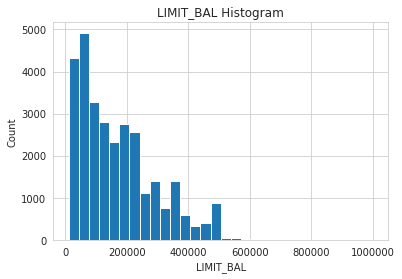

In [20]:
ccd_df.LIMIT_BAL.hist(bins=30)
plt.title("LIMIT_BAL Histogram")
plt.xlabel("LIMIT_BAL")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'LIMIT_BAL Box Plot')

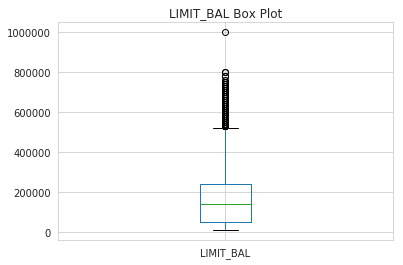

In [21]:
ccd_df.LIMIT_BAL.plot.box()
plt.title("LIMIT_BAL Box Plot")

Quite a few outliers.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

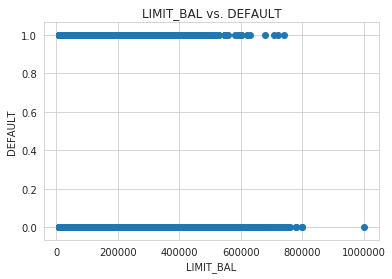

In [22]:
plt.scatter(ccd_df.LIMIT_BAL, ccd_df.DEFAULT)
plt.title("LIMIT_BAL vs. DEFAULT")
plt.xlabel("LIMIT_BAL")
plt.ylabel("DEFAULT")

In [23]:
ccd_df.LIMIT_BAL.corr(ccd_df.DEFAULT, method="spearman")

-0.16958627777128973

No clear relationship.

### SEX
Gender: ```Male = 1``` & ```Female = 2```.

In [24]:
ccd_df.SEX.value_counts(sort=False)

1    11888
2    18112
Name: SEX, dtype: int64

In [25]:
ccd_df.SEX.value_counts(sort=False, normalize=True)

1    0.396267
2    0.603733
Name: SEX, dtype: float64

Versus DEFAULT:

In [26]:
pd.crosstab(ccd_df.SEX, ccd_df.DEFAULT)

DEFAULT,0,1
SEX,,
1,9015,2873
2,14349,3763


In [27]:
pd.crosstab(ccd_df.SEX, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
SEX,,
1,0.758328,0.241672
2,0.792237,0.207763


Males tend to default slightly more than females.

Dummy:

In [28]:
sex_dummies = pd.get_dummies(ccd_df.SEX, prefix="SEX", drop_first=True)
ccd_df = pd.concat([ccd_df, sex_dummies], axis=1)
ccd_df.drop("SEX", axis=1, inplace=True)

Change variable's name to FEMALE:

In [29]:
ccd_df.rename(columns={"SEX_2": "FEMALE"}, inplace=True)

### EDUCATION
Education: ```Unknown = 0```, ```Graduate School = 1```, ```University = 2```, ```High School = 3```, ```Others = 4```, ```Unknown = 5```, & ```Unknown = 6```.

In [30]:
ccd_df.EDUCATION.value_counts(sort=False)

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [31]:
ccd_df.EDUCATION.value_counts(sort=False, normalize=True)

0    0.000467
1    0.352833
2    0.467667
3    0.163900
4    0.004100
5    0.009333
6    0.001700
Name: EDUCATION, dtype: float64

Versus DEFAULT:

In [32]:
pd.crosstab(ccd_df.EDUCATION, ccd_df.DEFAULT)

DEFAULT,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [33]:
pd.crosstab(ccd_df.EDUCATION, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


High school graduates tend to default slightly more than others.

Dummy:

In [34]:
education_dummies = pd.get_dummies(ccd_df.EDUCATION, prefix="EDUCATION", drop_first=True)
ccd_df = pd.concat([ccd_df, education_dummies], axis=1)
ccd_df.drop("EDUCATION", axis=1, inplace=True)

Change variables' names:

In [35]:
ccd_df.rename(columns={"EDUCATION_1": "GRADUATE_SCHOOL", "EDUCATION_2": "UNIVERSITY",
                       "EDUCATION_3": "HIGH_SCHOOL", "EDUCATION_4": "EDUCATION_OTHERS",
                       "EDUCATION_5": "EDUCATION_UNKNOWN_1", "EDUCATION_6": "EDUCATION_UNKNOWN_2"}, inplace=True)

### MARRIAGE
Marital Status: ```Unknown = 0```, ```Married = 1```, ```Single = 2```, & ```Others = 3```.

In [36]:
ccd_df.MARRIAGE.value_counts(sort=False)

0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

In [37]:
ccd_df.MARRIAGE.value_counts(sort=False, normalize=True)

0    0.001800
1    0.455300
2    0.532133
3    0.010767
Name: MARRIAGE, dtype: float64

Versus DEFAULT:

In [38]:
pd.crosstab(ccd_df.MARRIAGE, ccd_df.DEFAULT)

DEFAULT,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [39]:
pd.crosstab(ccd_df.MARRIAGE, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
MARRIAGE,,
0,0.907407,0.092593
1,0.765283,0.234717
2,0.790717,0.209283
3,0.739938,0.260062


Married people tend to default slightly more than single people.

Dummy:

In [40]:
marriage_dummies = pd.get_dummies(ccd_df.MARRIAGE, prefix="MARRIAGE", drop_first=True)
ccd_df = pd.concat([ccd_df, marriage_dummies], axis=1)
ccd_df.drop("MARRIAGE", axis=1, inplace=True)

Change variables' names:

In [41]:
ccd_df.rename(columns={"MARRIAGE_1": "MARRIED", "MARRIAGE_2": "SINGLE",
                       "MARRIAGE_3": "MARRIAGE_OTHERS"}, inplace=True)

### AGE
Age in years.

In [42]:
ccd_df.AGE.describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

Text(0, 0.5, 'Count')

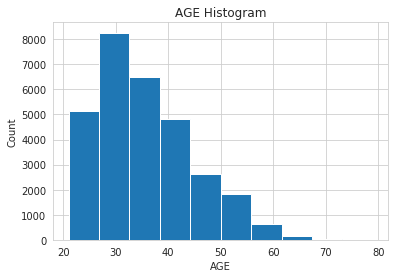

In [43]:
ccd_df.AGE.hist()
plt.title("AGE Histogram")
plt.xlabel("AGE")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'AGE Box Plot')

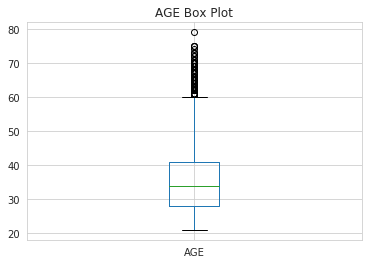

In [44]:
ccd_df.AGE.plot.box()
plt.title("AGE Box Plot")

Quite a few outliers.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

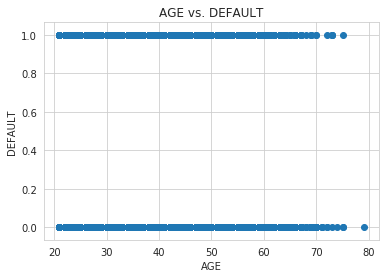

In [45]:
plt.scatter(ccd_df.AGE, ccd_df.DEFAULT)
plt.title("AGE vs. DEFAULT")
plt.xlabel("AGE")
plt.ylabel("DEFAULT")

In [46]:
ccd_df.AGE.corr(ccd_df.DEFAULT, method="spearman")

0.005148863519844661

No clear relationship.

### PAY_0
Repayment status in September, 2005.<br>
The measurement scale for the repayment status is: ```Pay Duly = -1```, ```Payment Delay for One Month = 1```, ```Payment Delay for Two Months = 2```, ..., ```Payment Delay for Eight Months = 8```, ```Payment Delay for Nine Months and Above = 9```.

In [47]:
ccd_df.PAY_0.value_counts(sort=False)

 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
-2     2759
-1     5686
Name: PAY_0, dtype: int64

In [48]:
ccd_df.PAY_0.value_counts(sort=False, normalize=True)

 0    0.491233
 1    0.122933
 2    0.088900
 3    0.010733
 4    0.002533
 5    0.000867
 6    0.000367
 7    0.000300
 8    0.000633
-2    0.091967
-1    0.189533
Name: PAY_0, dtype: float64

Where is ```9```? What are ```-2``` and ```0```?

Versus DEFAULT:

In [49]:
pd.crosstab(ccd_df.PAY_0, ccd_df.DEFAULT)

DEFAULT,0,1
PAY_0,,
-2,2394,365
-1,4732,954
0,12849,1888
1,2436,1252
2,823,1844
3,78,244
4,24,52
5,13,13
6,5,6


In [50]:
pd.crosstab(ccd_df.PAY_0, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
PAY_0,,
-2,0.867706,0.132294
-1,0.832219,0.167781
0,0.871887,0.128113
1,0.660521,0.339479
2,0.308586,0.691414
3,0.242236,0.757764
4,0.315789,0.684211
5,0.500000,0.500000
6,0.454545,0.545455


People with payment delay tend to default more than people who pay on time.

Dummy:

In [51]:
pay0_dummies = pd.get_dummies(ccd_df.PAY_0, prefix="REPAYMENT_STATUS_SEPT")
ccd_df = pd.concat([ccd_df, pay0_dummies], axis=1)
ccd_df.drop("PAY_0", axis=1, inplace=True)

### PAY_2
Repayment status in August, 2005.<br>
Same scale as above.

In [52]:
ccd_df.PAY_2.value_counts(sort=False)

 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
-2     3782
-1     6050
Name: PAY_2, dtype: int64

In [53]:
ccd_df.PAY_2.value_counts(sort=False, normalize=True)

 0    0.524333
 1    0.000933
 2    0.130900
 3    0.010867
 4    0.003300
 5    0.000833
 6    0.000400
 7    0.000667
 8    0.000033
-2    0.126067
-1    0.201667
Name: PAY_2, dtype: float64

Versus DEFAULT:

In [54]:
pd.crosstab(ccd_df.PAY_2, ccd_df.DEFAULT)

DEFAULT,0,1
PAY_2,,
-2,3091,691
-1,5084,966
0,13227,2503
1,23,5
2,1743,2184
3,125,201
4,49,50
5,10,15
6,3,9


In [55]:
pd.crosstab(ccd_df.PAY_2, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
PAY_2,,
-2,0.817292,0.182708
-1,0.840331,0.159669
0,0.840877,0.159123
1,0.821429,0.178571
2,0.443850,0.556150
3,0.383436,0.616564
4,0.494949,0.505051
5,0.400000,0.600000
6,0.250000,0.750000


Dummy:

In [56]:
pay2_dummies = pd.get_dummies(ccd_df.PAY_2, prefix="REPAYMENT_STATUS_AUG")
ccd_df = pd.concat([ccd_df, pay2_dummies], axis=1)
ccd_df.drop("PAY_2", axis=1, inplace=True)

### PAY_3
Repayment status in July, 2005.<br>
Same scale as above.

In [57]:
ccd_df.PAY_3.value_counts(sort=False)

 0    15764
 1        4
 2     3819
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
-2     4085
-1     5938
Name: PAY_3, dtype: int64

In [58]:
ccd_df.PAY_3.value_counts(sort=False, normalize=True)

 0    0.525467
 1    0.000133
 2    0.127300
 3    0.008000
 4    0.002533
 5    0.000700
 6    0.000767
 7    0.000900
 8    0.000100
-2    0.136167
-1    0.197933
Name: PAY_3, dtype: float64

Versus DEFAULT:

In [59]:
pd.crosstab(ccd_df.PAY_3, ccd_df.DEFAULT)

DEFAULT,0,1
PAY_3,,
-2,3328,757
-1,5012,926
0,13013,2751
1,3,1
2,1850,1969
3,102,138
4,32,44
5,9,12
6,9,14


In [60]:
pd.crosstab(ccd_df.PAY_3, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
PAY_3,,
-2,0.814688,0.185312
-1,0.844055,0.155945
0,0.825488,0.174512
1,0.750000,0.250000
2,0.484420,0.515580
3,0.425000,0.575000
4,0.421053,0.578947
5,0.428571,0.571429
6,0.391304,0.608696


Dummy:

In [61]:
pay3_dummies = pd.get_dummies(ccd_df.PAY_3, prefix="REPAYMENT_STATUS_JUL")
ccd_df = pd.concat([ccd_df, pay3_dummies], axis=1)
ccd_df.drop("PAY_3", axis=1, inplace=True)

### PAY_4
Repayment status in June, 2005.<br>
Same scale as above.

In [62]:
ccd_df.PAY_4.value_counts(sort=False)

 0    16455
 1        2
 2     3159
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
-2     4348
-1     5687
Name: PAY_4, dtype: int64

In [63]:
ccd_df.PAY_4.value_counts(sort=False, normalize=True)

 0    0.548500
 1    0.000067
 2    0.105300
 3    0.006000
 4    0.002300
 5    0.001167
 6    0.000167
 7    0.001933
 8    0.000067
-2    0.144933
-1    0.189567
Name: PAY_4, dtype: float64

Versus DEFAULT:

In [64]:
pd.crosstab(ccd_df.PAY_4, ccd_df.DEFAULT)

DEFAULT,0,1
PAY_4,,
-2,3511,837
-1,4783,904
0,13439,3016
1,1,1
2,1506,1653
3,70,110
4,23,46
5,17,18
6,3,2


In [65]:
pd.crosstab(ccd_df.PAY_4, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
PAY_4,,
-2,0.807498,0.192502
-1,0.841041,0.158959
0,0.816712,0.183288
1,0.500000,0.500000
2,0.476733,0.523267
3,0.388889,0.611111
4,0.333333,0.666667
5,0.485714,0.514286
6,0.600000,0.400000


Dummy:

In [66]:
pay4_dummies = pd.get_dummies(ccd_df.PAY_4, prefix="REPAYMENT_STATUS_JUN")
ccd_df = pd.concat([ccd_df, pay4_dummies], axis=1)
ccd_df.drop("PAY_4", axis=1, inplace=True)

### PAY_5
Repayment status in May, 2005.<br>
Same scale as above.

In [67]:
ccd_df.PAY_5.value_counts(sort=False)

 0    16947
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
-2     4546
-1     5539
Name: PAY_5, dtype: int64

In [68]:
ccd_df.PAY_5.value_counts(sort=False, normalize=True)

 0    0.564900
 2    0.087533
 3    0.005933
 4    0.002800
 5    0.000567
 6    0.000133
 7    0.001933
 8    0.000033
-2    0.151533
-1    0.184633
Name: PAY_5, dtype: float64

Versus DEFAULT:

In [69]:
pd.crosstab(ccd_df.PAY_5, ccd_df.DEFAULT)

DEFAULT,0,1
PAY_5,,
-2,3651,895
-1,4642,897
0,13752,3195
2,1203,1423
3,65,113
4,33,51
5,7,10
6,1,3
7,10,48


In [70]:
pd.crosstab(ccd_df.PAY_5, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
PAY_5,,
-2,0.803124,0.196876
-1,0.838057,0.161943
0,0.811471,0.188529
2,0.458111,0.541889
3,0.365169,0.634831
4,0.392857,0.607143
5,0.411765,0.588235
6,0.250000,0.750000
7,0.172414,0.827586


Dummy:

In [71]:
pay5_dummies = pd.get_dummies(ccd_df.PAY_5, prefix="REPAYMENT_STATUS_MAY")
ccd_df = pd.concat([ccd_df, pay5_dummies], axis=1)
ccd_df.drop("PAY_5", axis=1, inplace=True)

### PAY_6
Repayment status in April, 2005.<br>
Same scale as above.

In [72]:
ccd_df.PAY_6.value_counts(sort=False)

 0    16286
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
-2     4895
-1     5740
Name: PAY_6, dtype: int64

In [73]:
ccd_df.PAY_6.value_counts(sort=False, normalize=True)

 0    0.542867
 2    0.092200
 3    0.006133
 4    0.001633
 5    0.000433
 6    0.000633
 7    0.001533
 8    0.000067
-2    0.163167
-1    0.191333
Name: PAY_6, dtype: float64

Versus DEFAULT:

In [74]:
pd.crosstab(ccd_df.PAY_6, ccd_df.DEFAULT)

DEFAULT,0,1
PAY_6,,
-2,3914,981
-1,4765,975
0,13217,3069
2,1365,1401
3,66,118
4,18,31
5,6,7
6,5,14
7,8,38


In [75]:
pd.crosstab(ccd_df.PAY_6, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
PAY_6,,
-2,0.799591,0.200409
-1,0.830139,0.169861
0,0.811556,0.188444
2,0.493492,0.506508
3,0.358696,0.641304
4,0.367347,0.632653
5,0.461538,0.538462
6,0.263158,0.736842
7,0.173913,0.826087


Dummy:

In [76]:
pay6_dummies = pd.get_dummies(ccd_df.PAY_6, prefix="REPAYMENT_STATUS_APR")
ccd_df = pd.concat([ccd_df, pay6_dummies], axis=1)
ccd_df.drop("PAY_6", axis=1, inplace=True)

### BILL_AMT1
Amount of bill statement in September, 2005 (NT dollar).

In [77]:
ccd_df.BILL_AMT1.describe()

count     30000.000000
mean      51223.330900
std       73635.860576
min     -165580.000000
25%        3558.750000
50%       22381.500000
75%       67091.000000
max      964511.000000
Name: BILL_AMT1, dtype: float64

Text(0, 0.5, 'Count')

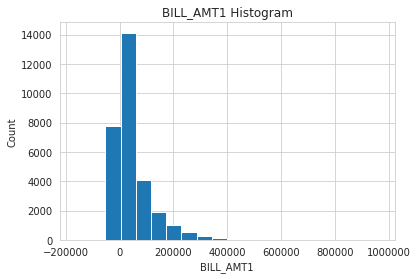

In [78]:
ccd_df.BILL_AMT1.hist(bins=20)
plt.title("BILL_AMT1 Histogram")
plt.xlabel("BILL_AMT1")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'BILL_AMT1 Box Plot')

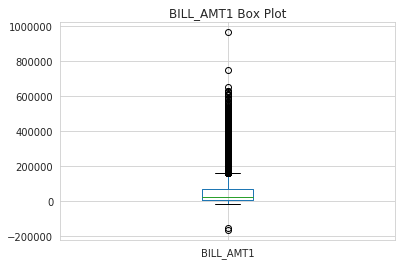

In [79]:
ccd_df.BILL_AMT1.plot.box()
plt.title("BILL_AMT1 Box Plot")

Two outliers on the lower bound and quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

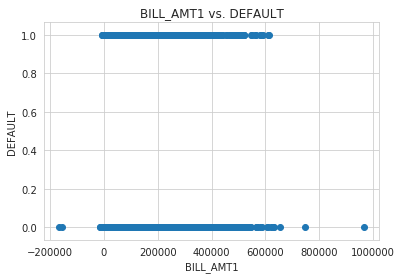

In [80]:
plt.scatter(ccd_df.BILL_AMT1, ccd_df.DEFAULT)
plt.title("BILL_AMT1 vs. DEFAULT")
plt.xlabel("BILL_AMT1")
plt.ylabel("DEFAULT")

In [81]:
ccd_df.BILL_AMT1.corr(ccd_df.DEFAULT, method="spearman")

-0.025326827533909278

No clear relationship.

Change variable's name to BILL_AMT_SEPT:

In [82]:
ccd_df.rename(columns={"BILL_AMT1": "BILL_AMT_SEPT"}, inplace=True)

### BILL_AMT2
Amount of bill statement in August, 2005 (NT dollar).

In [83]:
ccd_df.BILL_AMT2.describe()

count     30000.000000
mean      49179.075167
std       71173.768783
min      -69777.000000
25%        2984.750000
50%       21200.000000
75%       64006.250000
max      983931.000000
Name: BILL_AMT2, dtype: float64

Text(0, 0.5, 'Count')

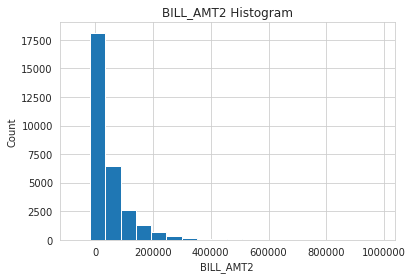

In [84]:
ccd_df.BILL_AMT2.hist(bins=20)
plt.title("BILL_AMT2 Histogram")
plt.xlabel("BILL_AMT2")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'BILL_AMT2 Box Plot')

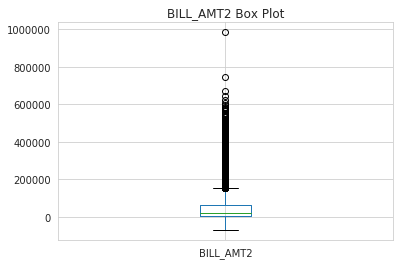

In [85]:
ccd_df.BILL_AMT2.plot.box()
plt.title("BILL_AMT2 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

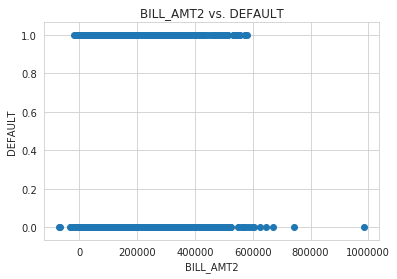

In [86]:
plt.scatter(ccd_df.BILL_AMT2, ccd_df.DEFAULT)
plt.title("BILL_AMT2 vs. DEFAULT")
plt.xlabel("BILL_AMT2")
plt.ylabel("DEFAULT")

In [87]:
ccd_df.BILL_AMT2.corr(ccd_df.DEFAULT, method="spearman")

-0.01555375617850131

No clear relationship.

Change variable's name to BILL_AMT_AUG:

In [88]:
ccd_df.rename(columns={"BILL_AMT2": "BILL_AMT_AUG"}, inplace=True)

### BILL_AMT3
Amount of bill statement in July, 2005 (NT dollar).

In [89]:
ccd_df.BILL_AMT3.describe()

count    3.000000e+04
mean     4.701315e+04
std      6.934939e+04
min     -1.572640e+05
25%      2.666250e+03
50%      2.008850e+04
75%      6.016475e+04
max      1.664089e+06
Name: BILL_AMT3, dtype: float64

Text(0, 0.5, 'Count')

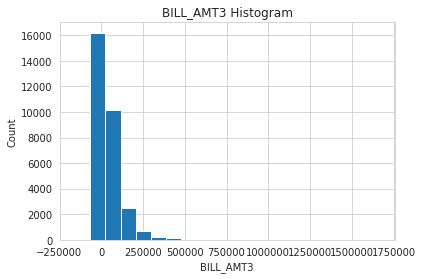

In [90]:
ccd_df.BILL_AMT3.hist(bins=20)
plt.title("BILL_AMT3 Histogram")
plt.xlabel("BILL_AMT3")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'BILL_AMT3 Box Plot')

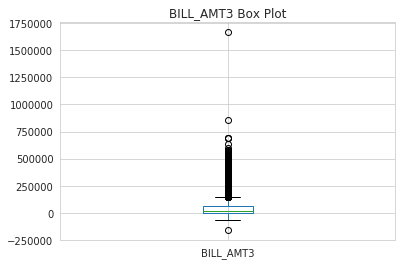

In [91]:
ccd_df.BILL_AMT3.plot.box()
plt.title("BILL_AMT3 Box Plot")

One outlier on the lower bound and quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

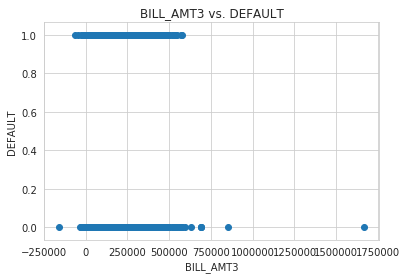

In [92]:
plt.scatter(ccd_df.BILL_AMT3, ccd_df.DEFAULT)
plt.title("BILL_AMT3 vs. DEFAULT")
plt.xlabel("BILL_AMT3")
plt.ylabel("DEFAULT")

In [93]:
ccd_df.BILL_AMT3.corr(ccd_df.DEFAULT, method="spearman")

-0.012669908803039634

No clear relationship.

Change variable's name to BILL_AMT_JUL:

In [94]:
ccd_df.rename(columns={"BILL_AMT3": "BILL_AMT_JUL"}, inplace=True)

### BILL_AMT4
Amount of bill statement in June, 2005 (NT dollar).

In [95]:
ccd_df.BILL_AMT4.describe()

count     30000.000000
mean      43262.948967
std       64332.856134
min     -170000.000000
25%        2326.750000
50%       19052.000000
75%       54506.000000
max      891586.000000
Name: BILL_AMT4, dtype: float64

Text(0, 0.5, 'Count')

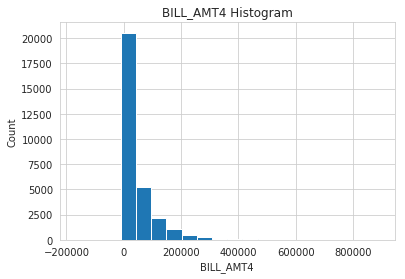

In [96]:
ccd_df.BILL_AMT4.hist(bins=20)
plt.title("BILL_AMT4 Histogram")
plt.xlabel("BILL_AMT4")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'BILL_AMT4 Box Plot')

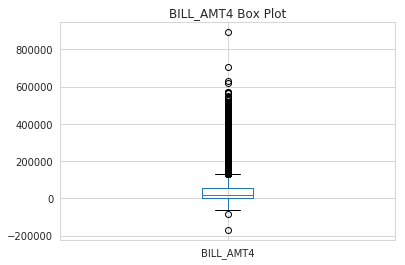

In [97]:
ccd_df.BILL_AMT4.plot.box()
plt.title("BILL_AMT4 Box Plot")

Two outliers on the lower bound and quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

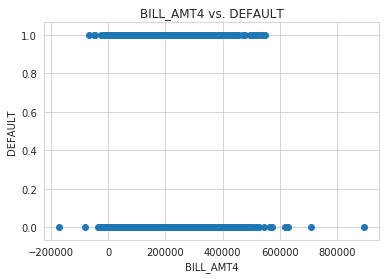

In [98]:
plt.scatter(ccd_df.BILL_AMT4, ccd_df.DEFAULT)
plt.title("BILL_AMT4 vs. DEFAULT")
plt.xlabel("BILL_AMT4")
plt.ylabel("DEFAULT")

In [99]:
ccd_df.BILL_AMT4.corr(ccd_df.DEFAULT, method="spearman")

-0.008357064590967862

No clear relationship.

Change variable's name to BILL_AMT_JUN:

In [100]:
ccd_df.rename(columns={"BILL_AMT4": "BILL_AMT_JUN"}, inplace=True)

### BILL_AMT5
Amount of bill statement in May, 2005 (NT dollar).

In [101]:
ccd_df.BILL_AMT5.describe()

count     30000.000000
mean      40311.400967
std       60797.155770
min      -81334.000000
25%        1763.000000
50%       18104.500000
75%       50190.500000
max      927171.000000
Name: BILL_AMT5, dtype: float64

Text(0, 0.5, 'Count')

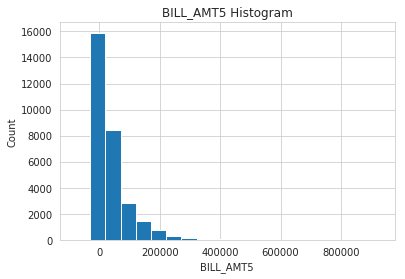

In [102]:
ccd_df.BILL_AMT5.hist(bins=20)
plt.title("BILL_AMT5 Histogram")
plt.xlabel("BILL_AMT5")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'BILL_AMT5 Box Plot')

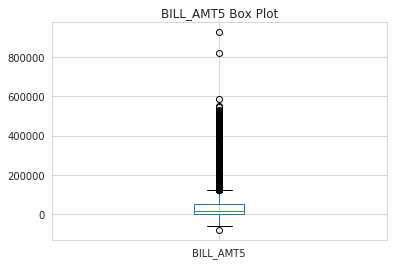

In [103]:
ccd_df.BILL_AMT5.plot.box()
plt.title("BILL_AMT5 Box Plot")

One outlier on the lower bound and quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

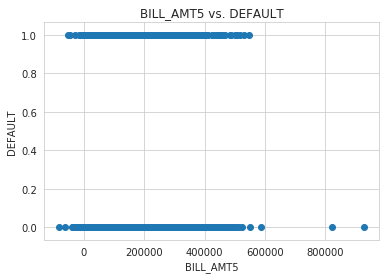

In [104]:
plt.scatter(ccd_df.BILL_AMT5, ccd_df.DEFAULT)
plt.title("BILL_AMT5 vs. DEFAULT")
plt.xlabel("BILL_AMT5")
plt.ylabel("DEFAULT")

In [105]:
ccd_df.BILL_AMT5.corr(ccd_df.DEFAULT, method="spearman")

-0.00685122651830854

No clear relationship.

Change variable's name to BILL_AMT_MAY:

In [106]:
ccd_df.rename(columns={"BILL_AMT5": "BILL_AMT_MAY"}, inplace=True)

### BILL_AMT6
Amount of bill statement in April, 2005 (NT dollar).

In [107]:
ccd_df.BILL_AMT6.describe()

count     30000.000000
mean      38871.760400
std       59554.107537
min     -339603.000000
25%        1256.000000
50%       17071.000000
75%       49198.250000
max      961664.000000
Name: BILL_AMT6, dtype: float64

Text(0, 0.5, 'Count')

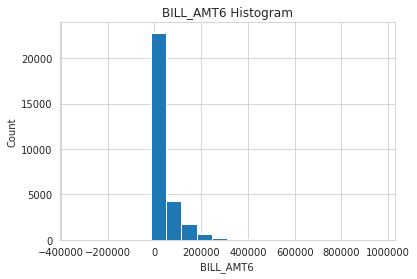

In [108]:
ccd_df.BILL_AMT6.hist(bins=20)
plt.title("BILL_AMT6 Histogram")
plt.xlabel("BILL_AMT6")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'BILL_AMT6 Box Plot')

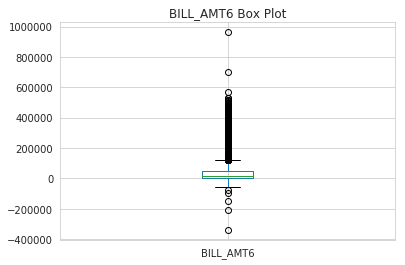

In [109]:
ccd_df.BILL_AMT6.plot.box()
plt.title("BILL_AMT6 Box Plot")

Five outliers on the lower bound and quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

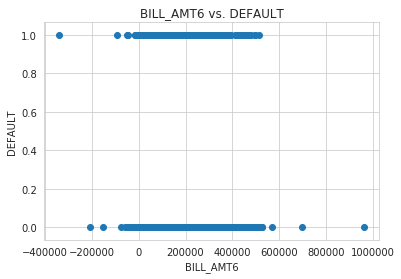

In [110]:
plt.scatter(ccd_df.BILL_AMT6, ccd_df.DEFAULT)
plt.title("BILL_AMT6 vs. DEFAULT")
plt.xlabel("BILL_AMT6")
plt.ylabel("DEFAULT")

In [111]:
ccd_df.BILL_AMT6.corr(ccd_df.DEFAULT, method="spearman")

-7.612488787045955e-05

No clear relationship.

Change variable's name to BILL_AMT_APR:

In [112]:
ccd_df.rename(columns={"BILL_AMT6": "BILL_AMT_APR"}, inplace=True)

### PAY_AMT1
Amount of previous payment in September, 2005 (NT dollar).

In [113]:
ccd_df.PAY_AMT1.describe()

count     30000.000000
mean       5663.580500
std       16563.280354
min           0.000000
25%        1000.000000
50%        2100.000000
75%        5006.000000
max      873552.000000
Name: PAY_AMT1, dtype: float64

Text(0, 0.5, 'Count')

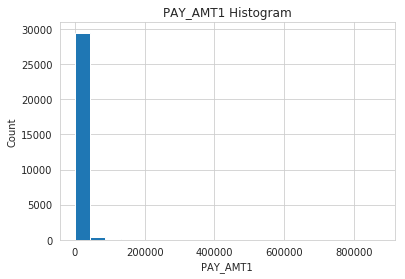

In [114]:
ccd_df.PAY_AMT1.hist(bins=20)
plt.title("PAY_AMT1 Histogram")
plt.xlabel("PAY_AMT1")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'PAY_AMT1 Box Plot')

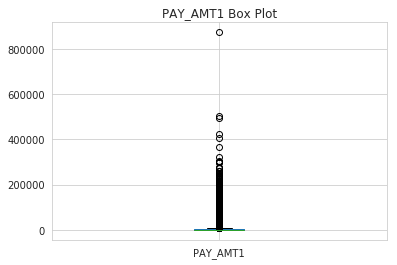

In [115]:
ccd_df.PAY_AMT1.plot.box()
plt.title("PAY_AMT1 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

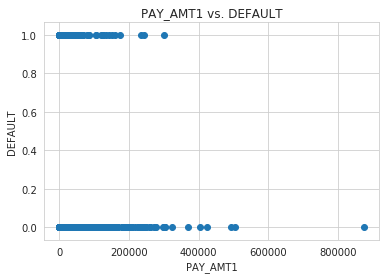

In [116]:
plt.scatter(ccd_df.PAY_AMT1, ccd_df.DEFAULT)
plt.title("PAY_AMT1 vs. DEFAULT")
plt.xlabel("PAY_AMT1")
plt.ylabel("DEFAULT")

In [117]:
ccd_df.PAY_AMT1.corr(ccd_df.DEFAULT, method="spearman")

-0.16049312738844118

No clear relationship but it does look like that people who pay more tend to default less.

Change variable's name to PAY_AMT_SEPT:

In [118]:
ccd_df.rename(columns={"PAY_AMT1": "PAY_AMT_SEPT"}, inplace=True)

### PAY_AMT2
Amount of previous payment in August, 2005 (NT dollar).

In [119]:
ccd_df.PAY_AMT2.describe()

count    3.000000e+04
mean     5.921163e+03
std      2.304087e+04
min      0.000000e+00
25%      8.330000e+02
50%      2.009000e+03
75%      5.000000e+03
max      1.684259e+06
Name: PAY_AMT2, dtype: float64

Text(0, 0.5, 'Count')

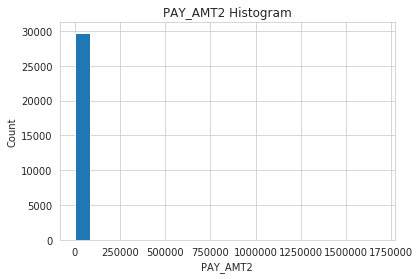

In [120]:
ccd_df.PAY_AMT2.hist(bins=20)
plt.title("PAY_AMT2 Histogram")
plt.xlabel("PAY_AMT2")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'PAY_AMT2 Box Plot')

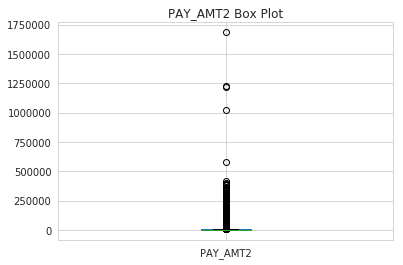

In [121]:
ccd_df.PAY_AMT2.plot.box()
plt.title("PAY_AMT2 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

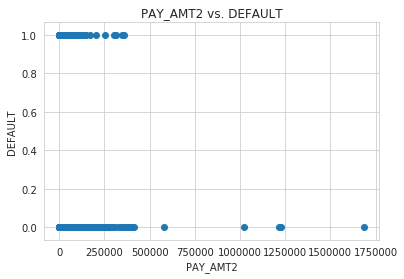

In [122]:
plt.scatter(ccd_df.PAY_AMT2, ccd_df.DEFAULT)
plt.title("PAY_AMT2 vs. DEFAULT")
plt.xlabel("PAY_AMT2")
plt.ylabel("DEFAULT")

In [123]:
ccd_df.PAY_AMT2.corr(ccd_df.DEFAULT, method="spearman")

-0.1509773960410106

No clear relationship but it does look like that people who pay more tend to default less.

Change variable's name to PAY_AMT_AUG:

In [124]:
ccd_df.rename(columns={"PAY_AMT2": "PAY_AMT_AUG"}, inplace=True)

### PAY_AMT3
Amount of previous payment in July, 2005 (NT dollar).

In [125]:
ccd_df.PAY_AMT3.describe()

count     30000.00000
mean       5225.68150
std       17606.96147
min           0.00000
25%         390.00000
50%        1800.00000
75%        4505.00000
max      896040.00000
Name: PAY_AMT3, dtype: float64

Text(0, 0.5, 'Count')

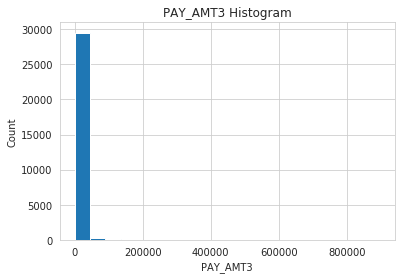

In [126]:
ccd_df.PAY_AMT3.hist(bins=20)
plt.title("PAY_AMT3 Histogram")
plt.xlabel("PAY_AMT3")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'PAY_AMT3 Box Plot')

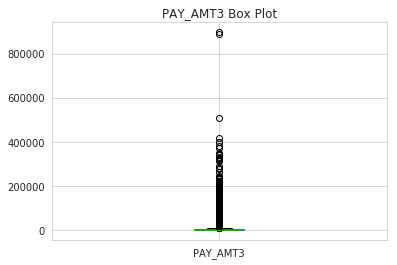

In [127]:
ccd_df.PAY_AMT3.plot.box()
plt.title("PAY_AMT3 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

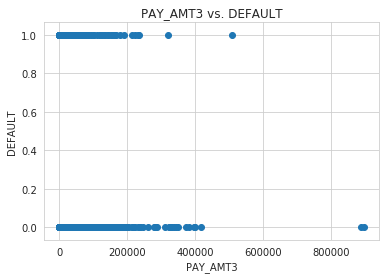

In [128]:
plt.scatter(ccd_df.PAY_AMT3, ccd_df.DEFAULT)
plt.title("PAY_AMT3 vs. DEFAULT")
plt.xlabel("PAY_AMT3")
plt.ylabel("DEFAULT")

In [129]:
ccd_df.PAY_AMT3.corr(ccd_df.DEFAULT, method="spearman")

-0.13938802702711522

No clear relationship but it does look like that people who pay more tend to default less.

Change variable's name to PAY_AMT_JUL:

In [130]:
ccd_df.rename(columns={"PAY_AMT3": "PAY_AMT_JUL"}, inplace=True)

### PAY_AMT4
Amount of previous payment in June, 2005 (NT dollar).

In [131]:
ccd_df.PAY_AMT4.describe()

count     30000.000000
mean       4826.076867
std       15666.159744
min           0.000000
25%         296.000000
50%        1500.000000
75%        4013.250000
max      621000.000000
Name: PAY_AMT4, dtype: float64

Text(0, 0.5, 'Count')

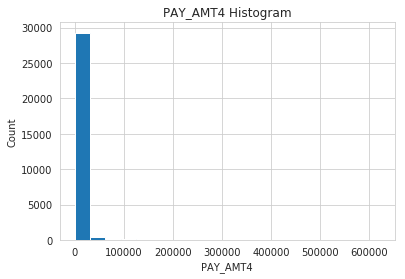

In [132]:
ccd_df.PAY_AMT4.hist(bins=20)
plt.title("PAY_AMT4 Histogram")
plt.xlabel("PAY_AMT4")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'PAY_AMT4 Box Plot')

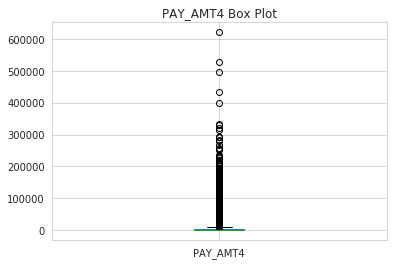

In [133]:
ccd_df.PAY_AMT4.plot.box()
plt.title("PAY_AMT4 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

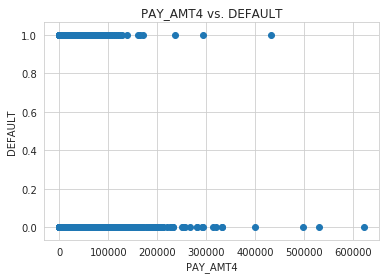

In [134]:
plt.scatter(ccd_df.PAY_AMT4, ccd_df.DEFAULT)
plt.title("PAY_AMT4 vs. DEFAULT")
plt.xlabel("PAY_AMT4")
plt.ylabel("DEFAULT")

In [135]:
ccd_df.PAY_AMT4.corr(ccd_df.DEFAULT, method="spearman")

-0.12797859795409017

No clear relationship but it does look like that people who pay more tend to default less.

Change variable's name to PAY_AMT_JUN:

In [136]:
ccd_df.rename(columns={"PAY_AMT4": "PAY_AMT_JUN"}, inplace=True)

### PAY_AMT5
Amount of previous payment in May, 2005 (NT dollar).

In [137]:
ccd_df.PAY_AMT5.describe()

count     30000.000000
mean       4799.387633
std       15278.305679
min           0.000000
25%         252.500000
50%        1500.000000
75%        4031.500000
max      426529.000000
Name: PAY_AMT5, dtype: float64

Text(0, 0.5, 'Count')

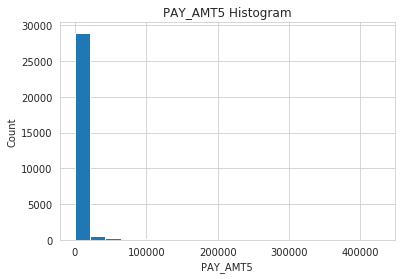

In [138]:
ccd_df.PAY_AMT5.hist(bins=20)
plt.title("PAY_AMT5 Histogram")
plt.xlabel("PAY_AMT5")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'PAY_AMT5 Box Plot')

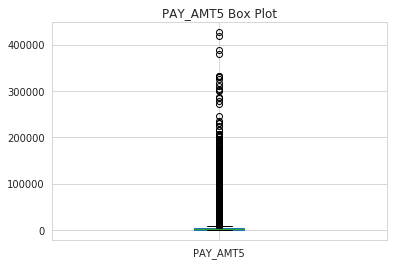

In [139]:
ccd_df.PAY_AMT5.plot.box()
plt.title("PAY_AMT5 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

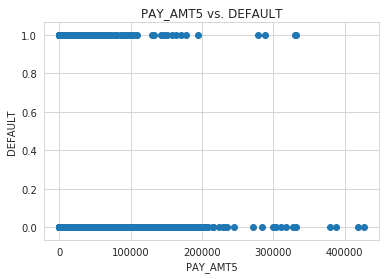

In [140]:
plt.scatter(ccd_df.PAY_AMT5, ccd_df.DEFAULT)
plt.title("PAY_AMT5 vs. DEFAULT")
plt.xlabel("PAY_AMT5")
plt.ylabel("DEFAULT")

In [141]:
ccd_df.PAY_AMT5.corr(ccd_df.DEFAULT, method="spearman")

-0.11658708671179431

No clear relationship but it does look like that people who pay more tend to default less.

Change variable's name to PAY_AMT_MAY:

In [142]:
ccd_df.rename(columns={"PAY_AMT5": "PAY_AMT_MAY"}, inplace=True)

### PAY_AMT6
Amount of previous payment in April, 2005 (NT dollar).

In [143]:
ccd_df.PAY_AMT6.describe()

count     30000.000000
mean       5215.502567
std       17777.465775
min           0.000000
25%         117.750000
50%        1500.000000
75%        4000.000000
max      528666.000000
Name: PAY_AMT6, dtype: float64

Text(0, 0.5, 'Count')

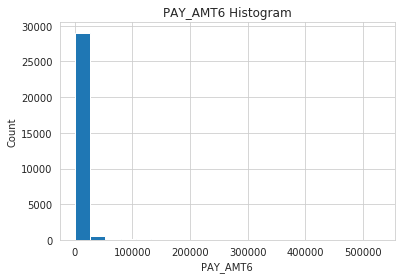

In [144]:
ccd_df.PAY_AMT6.hist(bins=20)
plt.title("PAY_AMT6 Histogram")
plt.xlabel("PAY_AMT6")
plt.ylabel("Count")

Not normally distributed.

Text(0.5, 1.0, 'PAY_AMT6 Box Plot')

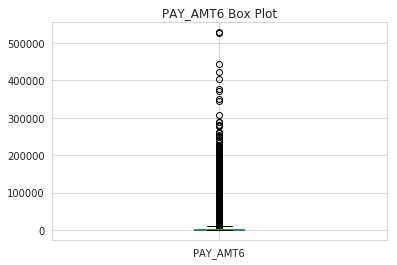

In [145]:
ccd_df.PAY_AMT6.plot.box()
plt.title("PAY_AMT6 Box Plot")

Quite a few outliers on the upper bound.

Versus DEFAULT:

Text(0, 0.5, 'DEFAULT')

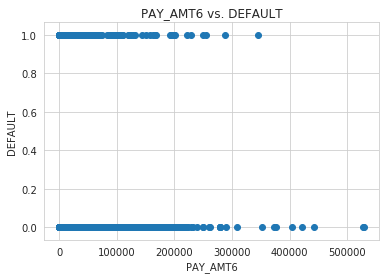

In [146]:
plt.scatter(ccd_df.PAY_AMT6, ccd_df.DEFAULT)
plt.title("PAY_AMT6 vs. DEFAULT")
plt.xlabel("PAY_AMT6")
plt.ylabel("DEFAULT")

In [147]:
ccd_df.PAY_AMT6.corr(ccd_df.DEFAULT, method="spearman")

-0.12144363905532163

No clear relationship but it does look like that people who pay more tend to default less.

Change variable's name to PAY_AMT_APR:

In [148]:
ccd_df.rename(columns={"PAY_AMT6": "PAY_AMT_APR"}, inplace=True)

-----------------------------
Let's call our dataset up until this point the original dataset.

In [149]:
ccd_df.shape

(30000, 89)

In [150]:
ccd_original = ccd_df.copy()

-------------------------------

## Transform & scale data

Since our numerical features have lots of outliers, contain negative values, and are not normally distributed, we will transform them using Yeo-Johnson transformation. We will then scale them using Min-Max scaler to get values between 0 and 1.

In [151]:
ccd_ts = ccd_df.copy()
X = ccd_ts.drop("DEFAULT", axis=1)
y = ccd_ts.DEFAULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [152]:
cols_ts = ["LIMIT_BAL", "AGE", "BILL_AMT_SEPT", "BILL_AMT_AUG", "BILL_AMT_JUL",
           "BILL_AMT_JUN", "BILL_AMT_MAY", "BILL_AMT_APR", "PAY_AMT_SEPT", "PAY_AMT_AUG",
           "PAY_AMT_JUL", "PAY_AMT_JUN", "PAY_AMT_MAY", "PAY_AMT_APR"]
X_train_no_ts = X_train.drop(cols_ts, axis=1)
X_test_no_ts = X_test.drop(cols_ts, axis=1)
X_train_ts = X_train[cols_ts]
X_test_ts = X_test[cols_ts]

In [153]:
yj = PowerTransformer(method="yeo-johnson")
X_t_train = pd.DataFrame(yj.fit_transform(X_train_ts), columns=cols_ts, index=X_train_ts.index)
X_t_test = pd.DataFrame(yj.transform(X_test_ts), columns=cols_ts, index=X_test_ts.index)

In [154]:
mm = MinMaxScaler()
X_ts_train = pd.DataFrame(mm.fit_transform(X_t_train), columns=cols_ts, index=X_train_ts.index)
X_ts_test = pd.DataFrame(mm.transform(X_t_test), columns=cols_ts, index=X_test_ts.index)

In [155]:
X_train = pd.concat([X_ts_train, X_train_no_ts], axis=1)
X_test = pd.concat([X_ts_test, X_test_no_ts], axis=1)

In [156]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
ccd_ts = pd.concat([train, test], axis=0, sort=True).sort_index()

# Save processed data

Change directory to save data:

In [157]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()

Save data:

In [158]:
ccd_original.to_csv("processed/non_transformed_credit_card_default.csv")
ccd_ts.to_csv("processed/transformed_credit_card_default.csv")

Change back to notebook directory:

In [159]:
cd.change_to_notebook_dir()

--------------------
**Sources:**<br>
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#<br>
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset